# Machine Learning

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor, LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import preprocessing # Label encoding and polynomial features. 

In [40]:
df = pd.read_csv(r'../data/zeefdrukken_data_cleaned.csv')

In [41]:
df = df[['Price', 'Artist', 'Hoogte', 'Breedte', 'Birth', 'Death', 'Ingelijst']].iloc[0:7100,:]
df['Death'] = df['Death'].fillna(3000)
df.dropna(inplace = True)

## Preprocessing

In [42]:
artist_count = df['Artist'].value_counts()
high_freq_artist = artist_count[artist_count > 100].index.tolist()
df = df.loc[df['Artist'].isin(high_freq_artist)]

# Generate binary values using get_dummies
dum_df = pd.get_dummies(df['Artist'], columns=['Artist'], prefix=None)
df.drop(columns = ['Artist'], inplace=True)

df['Area'] = df['Hoogte']*df['Breedte']

X = df.iloc[:,1:]
y = df.iloc[:,0]

# Add polynomial features
#polyfeatures = preprocessing.PolynomialFeatures(2)
#X = polyfeatures.fit_transform(X)

# Add artist
X = np.concatenate((X, dum_df), axis=1)

In [43]:
rng = np.random.RandomState()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

## Scaling

In [44]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train and score

In [46]:
from sklearn.neural_network import MLPRegressor

glm = PoissonRegressor()
glm.fit(X_train, y_train)
print('Poisson Regression: ', glm.score(X_test, y_test))

reg = LinearRegression()
reg.fit(X_train, y_train)
print('Linear Regression: ', reg.score(X_test, y_test))

regr = MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), random_state=1, activation='relu', \
                    learning_rate='adaptive', max_iter=1000)
regr.fit(X_train, y_train)
print('MLP Regressor: ', regr.score(X_test, y_test) )
#gbdt = HistGradientBoostingRegressor(loss='poisson', learning_rate=.01)
#gbdt.fit(X_train, y_train)
#print(gbdt.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Poisson Regression:  0.5523292854195001
Linear Regression:  0.47910649131829375
MLP Regressor:  0.5141648266438419


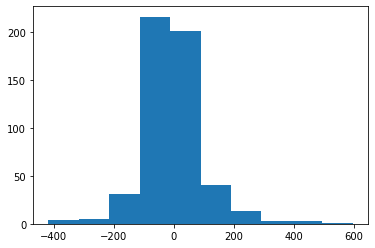

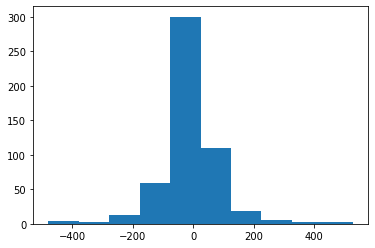

In [47]:
import matplotlib.pyplot as plt
pred = reg.predict(X_test)
pred_diff = y_test-pred
pred_mlp = regr.predict(X_test)
pred_diff_mlp = y_test-pred_mlp

plt.hist(pred_diff)
plt.show()
plt.hist(pred_diff_mlp)
plt.show()


## Validation curves

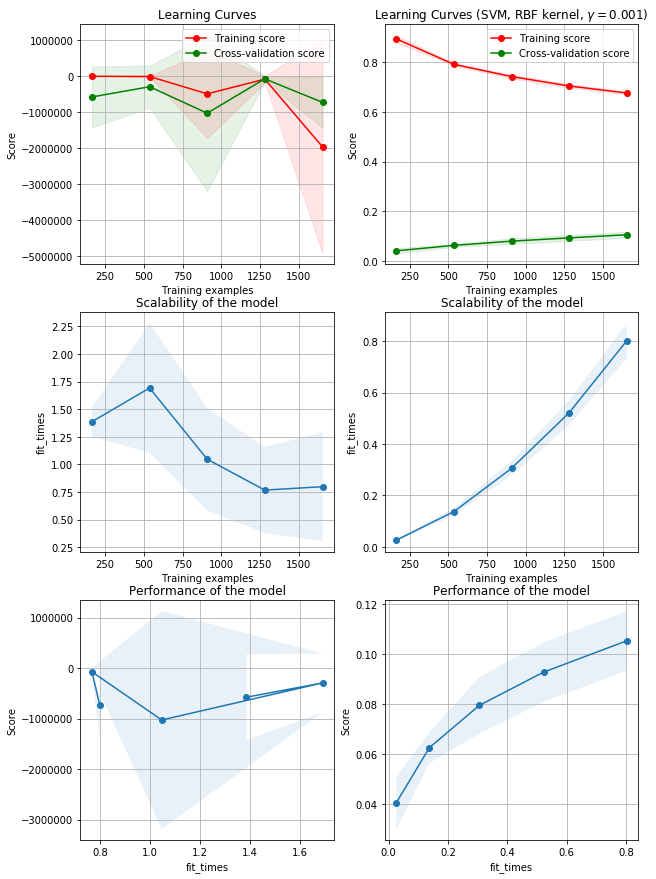

In [49]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LinearRegression()
estimator = MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), random_state=1, activation='relu', \
                    learning_rate='adaptive', max_iter=1000)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=None,
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=None,
                    cv=cv, n_jobs=4)

plt.show()

In [88]:
print(df.head(50))

     Price  Hoogte  Breedte   Birth   Death  Ingelijst    Area
2     92.0    55.0     45.0  1922.0  2010.0          0  2475.0
3    148.0    65.0     95.0  1946.0  2001.0          0  6175.0
5    230.0    54.0     76.0  1946.0  2001.0          0  4104.0
6    189.0    40.0    100.0  1955.0  3000.0          0  4000.0
13   454.0    31.0     36.0  1922.0  2010.0          1  1116.0
14   339.0   111.0     76.0  1946.0  2001.0          0  8436.0
15   339.0   111.0     76.0  1946.0  2001.0          0  8436.0
16   310.0   111.0     76.0  1946.0  2001.0          0  8436.0
19   488.0    88.0     70.0  1946.0  2001.0          1  6160.0
28   172.0    55.5     80.0  1940.0  3000.0          1  4440.0
32   488.0    74.0     60.0  1946.0  2001.0          1  4440.0
37   138.0    40.0     50.0  1922.0  2010.0          1  2000.0
43   276.0    75.0     90.0  1922.0  2010.0          0  6750.0
45   529.0    47.0     30.0  1946.0  2001.0          1  1410.0
46   862.0    68.0     80.0  1946.0  2001.0          1 